# Weather Prediction using Recurrent Neural Network
Data can be downloaded from https://www.kaggle.com/datasets/thedevastator/weather-prediction

## Import required libraries

In [37]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch.optim as optim

## Load data from csv file

In [5]:
df = pd.read_csv('weather_prediction_dataset.csv')
df.head()

,DATE,MONTH,BUDAPEST_temp_max,DE_BILT_temp_max,DRESDEN_temp_max
0,20000101,1,-0.7,8.1,2.0
1,20000102,1,-1.9,8.7,4.0
2,20000103,1,1.1,9.6,5.1
3,20000104,1,0.1,9.4,5.2
4,20000105,1,3.9,7.4,6.9


In [12]:
temp_df=df[['DATE', 'DE_BILT_temp_max']].dropna()
temp_df.head()

,DATE,DE_BILT_temp_max
0,20000101,8.1
1,20000102,8.7
2,20000103,9.6
3,20000104,9.4
4,20000105,7.4


In [91]:
temp_df.tail()

,DATE,DE_BILT_temp_max
3649,20091228,7.3
3650,20091229,1.7
3651,20091230,0.9
3652,20091231,0.5
3653,20100101,0.7


## Validation data

In [92]:
valid_mask=(temp_df['DATE']>=20090101) & (temp_df['DATE']<20100101)
masked_valid_df = temp_df.loc[valid_mask]
masked_valid_df['DATE'] = pd.to_datetime(masked_valid_df['DATE'], format='%Y%m%d')
masked_valid_df['event_date']=masked_valid_df['DATE'].dt.strftime('%Y-%m-%d')
masked_valid_df.head()

C:\Users\bimam\AppData\Local\Temp\ipykernel_80812\2816014657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_valid_df['DATE'] = pd.to_datetime(masked_valid_df['DATE'], format='%Y%m%d')
C:\Users\bimam\AppData\Local\Temp\ipykernel_80812\2816014657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_valid_df['event_date']=masked_valid_df['DATE'].dt.strftime('%Y-%m-%d')


,DATE,DE_BILT_temp_max,event_date
3288,2009-01-01,0.5,2009-01-01
3289,2009-01-02,1.9,2009-01-02
3290,2009-01-03,1.6,2009-01-03
3291,2009-01-04,3.5,2009-01-04
3292,2009-01-05,1.5,2009-01-05


## Test data

In [28]:
mask=(temp_df['DATE']>=20050101) & (temp_df['DATE']<20090101)
masked_temp_df = temp_df.loc[mask]
masked_temp_df['DATE'] = pd.to_datetime(masked_temp_df['DATE'], format='%Y%m%d')
masked_temp_df['event_date']=masked_temp_df['DATE'].dt.strftime('%Y-%m-%d')
masked_temp_df.head()

C:\Users\bimam\AppData\Local\Temp\ipykernel_80812\827462535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_temp_df['DATE'] = pd.to_datetime(masked_temp_df['DATE'], format='%Y%m%d')
C:\Users\bimam\AppData\Local\Temp\ipykernel_80812\827462535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_temp_df['event_date']=masked_temp_df['DATE'].dt.strftime('%Y-%m-%d')


,DATE,DE_BILT_temp_max,event_date
1827,2005-01-01,10.6,2005-01-01
1828,2005-01-02,8.6,2005-01-02
1829,2005-01-03,8.9,2005-01-03
1830,2005-01-04,9.3,2005-01-04
1831,2005-01-05,7.7,2005-01-05


In [29]:
masked_temp_df.describe()

,DATE,DE_BILT_temp_max
count,1461,1461.000000
mean,2007-01-01 00:00:00,14.972621
min,2005-01-01 00:00:00,-3.700000
25%,2006-01-01 00:00:00,9.300000
50%,2007-01-01 00:00:00,15.300000
75%,2008-01-01 00:00:00,20.300000
max,2008-12-31 00:00:00,35.700000
std,NaN,7.193925


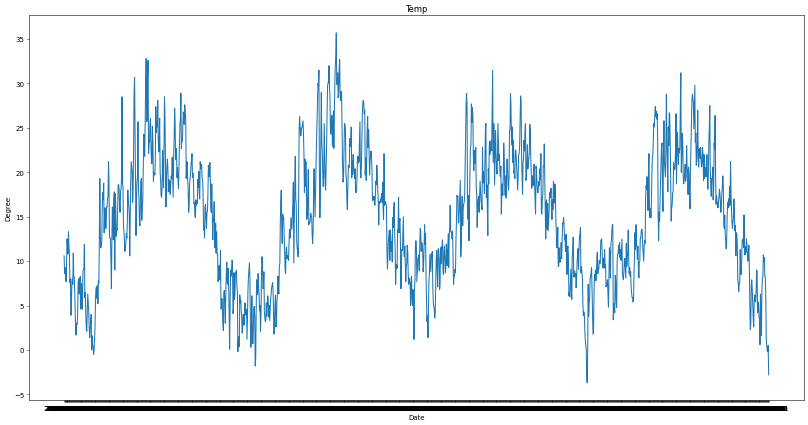

In [35]:
plt.figure(figsize=(20,10), dpi=50)
plt.plot(masked_temp_df['event_date'], masked_temp_df['DE_BILT_temp_max'])
plt.gca().set(title='Temp', xlabel='Date', ylabel="Degree")
plt.show()

## Create Network

In [38]:
class WeatherForecastRNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(WeatherForecastRNN, self).__init__()

        self.hidden_dim = hidden_dim

        self.rnn = nn.RNN(input_size, hidden_dim,  num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = x.view(-1, self.hidden_dim )

        x = self.fc(x)

        return x, hidden

## Explore RNN

In [39]:
input_size=1
hidden_dim=10
num_layers=2
output_size=1

test_rnn = WeatherForecastRNN(input_size, hidden_dim, num_layers, output_size)
test_rnn

WeatherForecastRNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

### Loss and Criterion

In [77]:
criterion = nn.MSELoss()
optimizer = optim.Adam(test_rnn.parameters(), lr=0.001)

### Input and Output

In [45]:
masked_temp_df['DE_BILT_temp_max'][:2]

1827    10.6
1828     8.6
Name: DE_BILT_temp_max, dtype: float64

In [46]:
test_df = np.array(masked_temp_df['DE_BILT_temp_max'][:2])
test_df.resize((2,1))
test_data = torch.Tensor(test_df).unsqueeze(0)

pred, hid= test_rnn(test_data, None)

print(f'Input size {test_data.size()}')
print(f'Hidden size {hid.size()}')
print(f'Output size {pred.size()}')

Input size torch.Size([1, 2, 1])
Hidden size torch.Size([2, 1, 10])
Output size torch.Size([2, 1])


## Helper function to train network

In [98]:
def train(input_size, hidden_dim, num_layers, output_size, print_every, seq_length, lrt):

    model = WeatherForecastRNN(input_size, hidden_dim, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lrt)
    print(test_rnn)
    hidden = None

    for i in range(len(masked_temp_df)-seq_length):
        input_df = np.array(masked_temp_df['DE_BILT_temp_max'][i:i+seq_length])
        input_df.resize((seq_length,1))
        input_df = torch.Tensor(input_df).unsqueeze(0)

        output_df =  np.array(masked_temp_df['DE_BILT_temp_max'][i+seq_length:i+2*seq_length])
        output_df.resize((seq_length,1))
        output_df = torch.Tensor(output_df).unsqueeze(0)

        r_out, hidden= model(input_df, hidden)
        hidden = hidden.data

        loss = criterion(r_out, output_df)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % print_every==0:
            model.eval()
            optimizer.zero_grad()
            vloss=0
            vloss_count=0
            for j in range(len(masked_valid_df)-seq_length):
                input_df = np.array(masked_valid_df['DE_BILT_temp_max'][j:j+seq_length])
                input_df.resize((seq_length,1))
                input_df = torch.Tensor(input_df).unsqueeze(0)

                output_df =  np.array(masked_valid_df['DE_BILT_temp_max'][j+seq_length:j+2*seq_length])
                output_df.resize((seq_length,1))
                output_df = torch.Tensor(output_df).unsqueeze(0)

                r_out, hidden= model(input_df, hidden)
                vloss += criterion(r_out, output_df)
                vloss_count+=1

                
            print(f'Test Loss: {loss.item()}, Verification loss: {vloss/vloss_count}')
            model.train()
    return model

In [106]:
trained_model = train(
    input_size=1, 
    hidden_dim=10, 
    num_layers=3, 
    output_size=1, 
    print_every=50, 
    seq_length=40, 
    lrt=0.001
    )

WeatherForecastRNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
Test Loss: 60.30628204345703, Verification loss: 301.6134948730469
Test Loss: 217.4079132080078, Verification loss: 259.437744140625
Test Loss: 410.7327575683594, Verification loss: 226.68051147460938
Test Loss: 342.93597412109375, Verification loss: 205.38990783691406
Test Loss: 301.40057373046875, Verification loss: 189.48377990722656
Test Loss: 96.51091003417969, Verification loss: 177.79209899902344
Test Loss: 8.530558586120605, Verification loss: 173.537353515625
Test Loss: 6.851252555847168, Verification loss: 173.2025909423828
Test Loss: 72.11358642578125, Verification loss: 171.1641387939453
Test Loss: 246.54031372070312, Verification loss: 160.68460083007812
Test Loss: 461.04986572265625, Verification loss: 146.02670288085938
Test Loss: 248.57150268554688, Verification loss: 132.0236053466797
Test Loss: 80.09568786621094, Verification loss: 122.29